In [43]:
# import necessities
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt


In [44]:
# futures contract details
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [45]:
# data cleansing
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


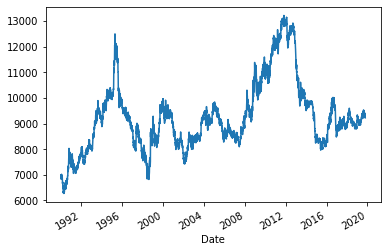

In [46]:
# plot the settle price
yen_futures.Settle.plot()

In [47]:
# decompose settle price using hodrick-prescott filter
import statsmodels.api as sm

ysettle_noise, ysettle_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])


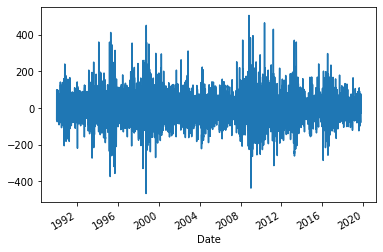

In [48]:
ysettle_noise.plot()

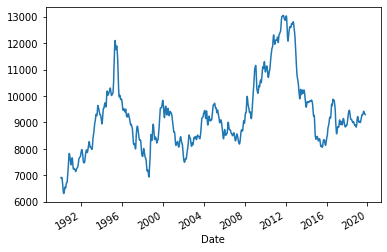

In [49]:
ysettle_trend.plot()

In [50]:
# create dataframe of just settle price
yen_settle = yen_futures[['Settle']]
raw_yen = yen_futures[['Settle']]

yen_settle.head()


,Settle
Date,
1990-01-02,6847.0
1990-01-03,6887.0
1990-01-04,7008.0
1990-01-05,6950.0
1990-01-08,6959.0


In [51]:
# add trend and noise to settle dataframe
yen_settle.insert(1, "Trend", ysettle_trend)

yen_settle.head()


,Settle,Trend
Date,,
1990-01-02,6847.0,6908.503967
1990-01-03,6887.0,6908.799756
1990-01-04,7008.0,6909.057104
1990-01-05,6950.0,6909.223948
1990-01-08,6959.0,6909.310062


In [52]:
yen_settle.insert(2, "Noise", ysettle_noise)

yen_settle.head()

,Settle,Trend,Noise
Date,,,
1990-01-02,6847.0,6908.503967,-61.503967
1990-01-03,6887.0,6908.799756,-21.799756
1990-01-04,7008.0,6909.057104,98.942896
1990-01-05,6950.0,6909.223948,40.776052
1990-01-08,6959.0,6909.310062,49.689938


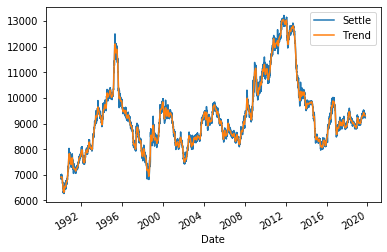

In [53]:
# plot the settle price vs. the trend
yen_settle.plot(y=["Settle", "Trend"])

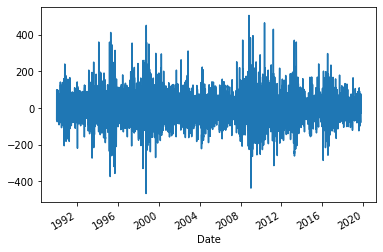

In [54]:
# plot the settle noise
yen_settle.Noise.plot()

In [55]:
# forecasting returns using ARMA
# create a series using settle price
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()

preserved_returns = returns

# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')

returns.tail()


,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [56]:
# estimate and ARMA model (use order=(2, 1))
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, pacf
from time import time
from datetime import datetime

# convert string index to datetime
returns.index = pd.DatetimeIndex(returns.index).to_period('A')

settle_mod = ARMA(returns, order=(2, 1))
results = settle_mod.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sun, 12 Jul 2020   AIC                          15798.142
Time:                        15:27:29   BIC                          15832.765
Sample:                    12-31-1990   HQIC                         15810.030
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.Settle    -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.09

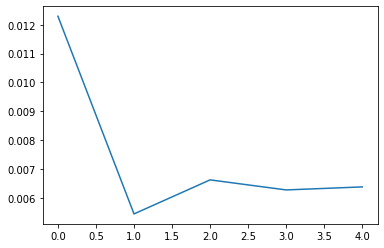

In [57]:
# plot the 5 day returns forecast

yen_forecast = results.forecast(steps = 5)[0]

yen_forecast

plt.plot(yen_forecast)

In [58]:
# forecasting using the ARIMA model
# raw settle data is raw_yen
# set p=5, d=1, q=1; arima(df, order=(p, d, q))

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

settle_mod2 = ARIMA(raw_yen, order=(5, 1, 1))
results2 = settle_mod2.fit(disp=0)
results2.summary()


C:\Users\jholl\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jholl\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sun, 12 Jul 2020   AIC                          83905.238
Time:                        15:27:31   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2824      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2974      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3784j            2.3409           -0.1002
AR.2            1.8920           +1.3784j            2.3409            0.1002
AR.3           -2.2711           -3.0200j            3.7787           -0.3526
AR.4           -2.2711           +3.0200j            3.7787            0.3526
AR.5          -11.1050           -0.0000j           11.1050           -0.5000
MA.1            3.3622           +0.0000j            3.3622            0.0000
-----------------------------------------------------------------------------
"""

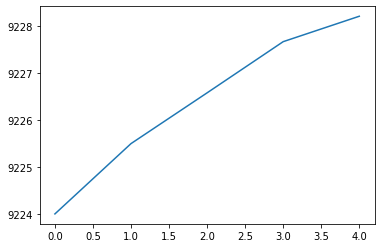

In [59]:
# plot 5 day price forecast
yen_forecast2 = results2.forecast(steps = 5)[0]

plt.plot(yen_forecast2)

In [60]:
# garch model using returns
import arch as arch
from arch import arch_model

gmodel = arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)
gresults = gmodel.fit(disp='off')


In [61]:
# garch model summary
gresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sun, Jul 12 2020   Df Residuals:                     7510
Time:                        15:27:31   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [62]:
# Find the last day of the dataset

last_day
# last_day2 = returns.index.max().strftime('%Y-%m-%d')

'2019-10-15'

In [63]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# must convert date back to datetime64 format
from datetime import time
from datetime import date
from datetime import datetime

# returns.dtypes = date is object, settle is float

# returns['Date'] = pd.to_datetime(returns['Date']).to_frame()

# returns['Date'] = pd.to_datetime(returns['Date'], format=''%Y-%m-%d')
# returns.index = pd.to_datetime(returns.index)

g_forecast5 = gresults.forecast(start=last_day, horizon=forecast_horizon)

ValueError: date_index must be a datetime64 array

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(g_forecast5.variance.dropna() * 252)
intermediate.head()